In [204]:
# Read in and clean data

import io
from google.colab import files
uploaded = files.upload()

import nltk
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import string

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
messages['label'] = np.where(messages['label']=='spam', 1, 0)

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

messages['clean_text'] = messages['text'].apply(lambda x: clean_text(x))
messages.head()

Saving spam.csv to spam.csv
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [205]:
messages.groupby('label').describe()

text         ...                                         clean_text     
      count unique  ...                                                top freq
label               ...                                                        
0      4825   4516  ...                          [sorry, ill, call, later]   30
1       747    653  ...  [camera, awarded, sipix, digital, camera, call...    4

[2 rows x 8 columns]

In [206]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(messages['clean_text'],
                                                    messages['label'], test_size=0.2)

X_train[:]
y_train[:10]

4006    0
373     0
1686    1
3023    0
2326    0
435     0
698     0
3480    0
2494    0
709     1
Name: label, dtype: int64

In [207]:
X_train.to_csv('X_train.csv', index=False, header=True)
X_test.to_csv('X_test.csv', index=False, header=True)
y_train.to_csv('y_train.csv', index=False, header=True)
y_test.to_csv('y_test.csv', index=False, header=True)

In [208]:
print("Train Size: ",X_train.size)
print("Test Size: ",X_test.size)

Train Size:  4457
Test Size:  1115


# Tf-IDF Embedding

In [244]:
# Load the cleaned training and test sets
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train.head()


,clean_text
0,"['im', 'reaching', 'home', '5', 'min']"
1,"['cant', 'keep', 'talking', 'people', 'sure', ..."
2,"['todays', 'vodafone', 'numbers', 'ending', '0..."
3,"['love', 'ya', 'try', 'budget', 'money', 'bett..."
4,"['xmas', 'story', 'peace', 'xmas', 'msg', 'lov..."


In [245]:
# Instantiate and fit a TFIDF vectorizer and then use that trained vectorizer
# to transform the messages in the training and test sets
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train['clean_text'])
X_train_vect = tfidf_vect.transform(X_train['clean_text'])
X_test_vect = tfidf_vect.transform(X_test['clean_text'])

In [246]:
tfidf_vect.vocabulary_

X_test_vect[0]
X_test_vect[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [247]:
X_train_vect

<4457x8347 sparse matrix of type '<class 'numpy.float64'>'
	with 37792 stored elements in Compressed Sparse Row format>

In [248]:
X_test_vect

<1115x8347 sparse matrix of type '<class 'numpy.float64'>'
	with 8333 stored elements in Compressed Sparse Row format>

In [249]:
# Random Forest Classifier on model
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier()
rf1_model = rf1.fit(X_train_vect, y_train.values.ravel())

In [251]:
# Use the trained model to make predictions on the test data
y_pred_1 = rf1_model.predict(X_test_vect)
print('predicted:', rf1_model.predict(X_test_vect)[9])
print('expected:', y_test.label[9])

predicted: 1
expected: 1


In [252]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred_1)
recall = recall_score(y_test, y_pred_1)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred_1==y_test['label']).sum()/len(y_pred_1), 3)))

Precision: 1.0 / Recall: 0.806 / Accuracy: 0.976


In [253]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       976
           1       1.00      0.81      0.89       139

    accuracy                           0.98      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.98      0.98      0.97      1115



# Word2-Vec Embedding

In [254]:
# Load the cleaned training and test sets
import gensim
import numpy as np
import pandas as pd

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train.head()

,clean_text
0,"['im', 'reaching', 'home', '5', 'min']"
1,"['cant', 'keep', 'talking', 'people', 'sure', ..."
2,"['todays', 'vodafone', 'numbers', 'ending', '0..."
3,"['love', 'ya', 'try', 'budget', 'money', 'bett..."
4,"['xmas', 'story', 'peace', 'xmas', 'msg', 'lov..."


In [255]:
# Train a basic word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   size=100,
                                   window=5,
                                   min_count=2)

In [256]:
# Replace the words in each text message with the learned word vector
words = set(w2v_model.wv.index2word)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train['clean_text']])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test['clean_text']])

In [257]:
# Average the word vectors for each sentence (and assign a vector of zeros if the model
# did not learn any of the words in the text message during training
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [258]:
X_train_vect[0]

array([[ 1.0416004e-03,  2.5522893e-03, -2.6325227e-03, -3.6821777e-03,
        -4.1848519e-03,  2.3913318e-03,  2.8844210e-03, -3.7382899e-03,
        -1.0611778e-03,  4.6505556e-03,  1.9733794e-03,  3.1042793e-03,
        -2.9815924e-03,  4.1127796e-03,  1.9411668e-03,  1.5439626e-03,
        -2.6310033e-03, -4.4225124e-03, -3.5966008e-03, -4.7332551e-03,
        -1.0604294e-03,  2.7253137e-03, -3.3891164e-03,  4.6196411e-04,
        -4.4773542e-03, -1.2010775e-04, -1.9259945e-03, -3.2004900e-04,
         3.5961815e-03,  2.6564808e-03,  3.9415481e-03,  9.7186369e-04,
         1.3614771e-03, -1.3173712e-04, -4.8026998e-04,  9.5903338e-04,
         1.5608285e-03, -1.3870504e-03, -2.8484433e-03,  3.0966836e-03,
         2.5914577e-03, -3.9573759e-03, -1.8849564e-03, -1.1841826e-03,
         4.3962817e-03,  3.5335589e-03,  2.8641408e-03,  2.4867787e-03,
         9.6560037e-04,  3.3743905e-03, -2.3122954e-03, -3.1363301e-04,
        -4.6536853e-03, -1.6194470e-03,  2.4592386e-05,  1.96103

In [259]:
X_train_vect_avg[0]

array([ 1.0416004e-03,  2.5522893e-03, -2.6325227e-03, -3.6821777e-03,
       -4.1848519e-03,  2.3913318e-03,  2.8844210e-03, -3.7382899e-03,
       -1.0611778e-03,  4.6505556e-03,  1.9733794e-03,  3.1042793e-03,
       -2.9815924e-03,  4.1127796e-03,  1.9411668e-03,  1.5439626e-03,
       -2.6310033e-03, -4.4225124e-03, -3.5966008e-03, -4.7332551e-03,
       -1.0604294e-03,  2.7253137e-03, -3.3891164e-03,  4.6196411e-04,
       -4.4773542e-03, -1.2010775e-04, -1.9259945e-03, -3.2004900e-04,
        3.5961815e-03,  2.6564808e-03,  3.9415481e-03,  9.7186369e-04,
        1.3614771e-03, -1.3173712e-04, -4.8026998e-04,  9.5903338e-04,
        1.5608285e-03, -1.3870504e-03, -2.8484433e-03,  3.0966836e-03,
        2.5914577e-03, -3.9573759e-03, -1.8849564e-03, -1.1841826e-03,
        4.3962817e-03,  3.5335589e-03,  2.8641408e-03,  2.4867787e-03,
        9.6560037e-04,  3.3743905e-03, -2.3122954e-03, -3.1363301e-04,
       -4.6536853e-03, -1.6194470e-03,  2.4592386e-05,  1.9610361e-03,
      

In [265]:
from sklearn.ensemble import RandomForestClassifier

rf_2 = RandomForestClassifier()
rf2_model = rf_2.fit(X_train_vect_avg, y_train.values.ravel())

In [266]:
y_pred_2 = rf2_model.predict(X_test_vect_avg)

In [268]:
# Use the trained model to make predictions on the test data
y_pred_2 = rf2_model.predict(X_test_vect_avg)
print('predicted:', rf2_model.predict(X_test_vect_avg)[9])
print('expected:', y_test.label[9])

predicted: 0
expected: 1


In [269]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred_2)
recall = recall_score(y_test, y_pred_2)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred_2==y_test['label']).sum()/len(y_pred_2), 3)))

Precision: 0.533 / Recall: 0.23 / Accuracy: 0.879


In [270]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       976
           1       0.53      0.23      0.32       139

    accuracy                           0.88      1115
   macro avg       0.72      0.60      0.63      1115
weighted avg       0.85      0.88      0.86      1115



# RNN Model

In [272]:
# Load the cleaned training and test sets
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# import pandas as pd

import io
from google.colab import files
uploaded = files.upload()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

X_train = pd.read_csv(io.BytesIO(uploaded['X_train.csv']))
X_test = pd.read_csv(io.BytesIO(uploaded['X_test.csv']))
y_train = pd.read_csv(io.BytesIO(uploaded['y_train.csv']))
y_test = pd.read_csv(io.BytesIO(uploaded['y_test.csv']))

Saving X_test.csv to X_test (1).csv
Saving X_train.csv to X_train (1).csv
Saving y_test.csv to y_test (1).csv
Saving y_train.csv to y_train (1).csv


In [273]:
print(X_train)

                                             clean_text
0            ['kkwhy', 'cant', 'come', 'search', 'job']
1     ['yup', 'hey', 'one', 'day', 'fri', 'ask', 'mi...
2                    ['ya', 'even', 'cookies', 'jelly']
3     ['think', 'û', 'waiting', 'bus', 'inform', 'ge...
4               ['lol', 'mad', 'first', 'woke', 'gave']
...                                                 ...
4452         ['going', 'write', 'ccna', 'exam', 'week']
4453                         ['home', 'always', 'chat']
4454  ['urgent', 'mobile', '07808726822', 'awarded',...
4455                                  ['number', 'sir']
4456  ['dont', 'cancer', 'moms', 'making', 'big', 'd...

[4457 rows x 1 columns]


In [274]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [275]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train['clean_text'])

one_hot_results = tokenizer.texts_to_matrix(X_train['clean_text'], mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

model = Sequential()

model.add(Embedding(len(word_index)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()



Found 8261 unique tokens.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          264384    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 273,793
Trainable params: 273,793
Non-trainable params: 0
_________________________________________________________________


In [276]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [277]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train['label'], 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 4s 29ms/step - loss: 0.2632 - accuracy: 0.9094 - precision_m: 0.4331 - recall_m: 0.3269 - val_loss: 0.0778 - val_accuracy: 0.9821 - val_precision_m: 0.9600 - val_recall_m: 0.8720
Epoch 2/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0375 - accuracy: 0.9892 - precision_m: 0.9703 - recall_m: 0.9341 - val_loss: 0.0587 - val_accuracy: 0.9839 - val_precision_m: 0.9657 - val_recall_m: 0.8808
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0127 - accuracy: 0.9980 - precision_m: 0.9918 - recall_m: 0.9774 - val_loss: 0.0550 - val_accuracy: 0.9865 - val_precision_m: 1.0000 - val_recall_m: 0.9151
Epoch 4/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0054 - accuracy: 0.9987 - precision_m: 0.9847 - recall_m: 0.9791 - val_loss: 0.0528 - val_accuracy: 0.9857 - val_precision_m: 0.9752 - val_recall_m: 0.9297
Epoch 5/10
140/140 [==============================] - 4s 26ms/step -

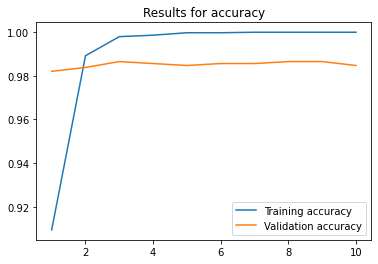

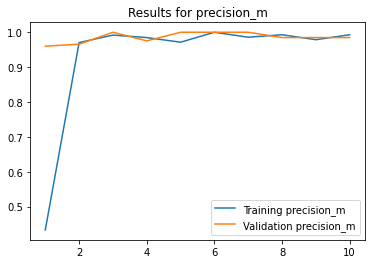

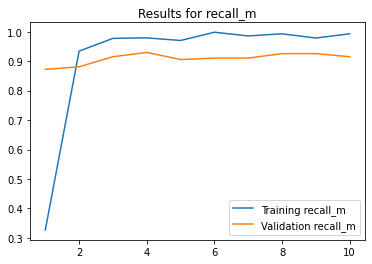

In [296]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label=("Training " + i))
    plt.plot(epochs, val_acc, label='Validation '+ i)
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

In [297]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test_seq_padded)
print('predicted:', model.predict(X_test_seq_padded)[9])
print('expected:', y_test.label[9])

predicted: [5.0294257e-06]
expected: 0
